In [1]:
import openpyxl
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math


In [2]:
shap.initjs()

### Data Loading and Cleaning

In [3]:
sheets = ['Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues']

In [4]:
df_soc = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx', sheet_name=sheets[0])
df_soc.head()

,Client,Sex,Age,Tenure
0,909,M,21,27
1,1217,M,38,165
2,850,F,49,44
3,1473,M,54,34
4,1038,M,29,106


In [5]:
df_soc.describe()

,Client,Age,Tenure
count,1615.000000,1615.000000,1615.000000
mean,808.000000,42.848916,101.339938
std,466.354658,18.550529,64.917297
min,1.000000,0.000000,0.000000
25%,404.500000,29.000000,44.000000
50%,808.000000,41.000000,97.000000
75%,1211.500000,57.000000,151.000000
max,1615.000000,97.000000,273.000000


In [6]:
df_prod = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx', sheet_name=sheets[1])
df_prod.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [7]:
df_prod.describe()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,1615.000000,1615.000000,426.000000,306.000000,419.0,170.0,135.000000,1615.000000,426.000000,306.000000,419.000000,170.000000,135.000000
mean,808.000000,1.078638,1.166667,4.676471,1.0,1.0,1.185185,2438.601941,15201.520284,20517.533479,126.449897,351.295420,4237.641981
std,466.354658,0.333035,0.468205,7.845009,0.0,0.0,0.520980,7072.777350,32365.183430,78046.994833,290.573266,486.679857,4167.134365
min,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000
25%,404.500000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,61.562143,728.145000,0.000000,0.000000,1.241071,1020.163393
50%,808.000000,1.000000,1.000000,2.000000,1.0,1.0,1.000000,462.221786,4413.503571,1700.943036,0.000000,153.006071,3141.900000
75%,1211.500000,1.000000,1.000000,5.000000,1.0,1.0,1.000000,2174.864286,14622.666071,11169.181339,93.114286,545.008839,5851.657679
max,1615.000000,4.000000,5.000000,79.000000,1.0,1.0,5.000000,171575.889643,389883.830714,761235.504286,2055.325357,3522.233571,20749.294643


In [8]:
## We can replace NaN with 0 in the above table as for Counts 0 will mean dont have and as of Balance also 0 will mean dont have
df_prod = df_prod.fillna(0)
df_prod.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,0.0,0.0,1.0,0.0,0.0,1333.802857,0.000000,0.000000,0.0,0.000000,0.0
1,2,1,1.0,0.0,0.0,0.0,0.0,110.768571,13326.190357,0.000000,0.0,0.000000,0.0
2,3,1,0.0,1.0,0.0,0.0,0.0,482.654643,0.000000,107.251786,0.0,0.000000,0.0
3,4,1,1.0,0.0,0.0,1.0,0.0,1599.840714,76.437143,0.000000,0.0,1110.381786,0.0
4,5,1,1.0,0.0,0.0,0.0,0.0,5353.483929,8079.715714,0.000000,0.0,0.000000,0.0


In [9]:
df_io = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx', sheet_name=sheets[2])
df_io.head()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [10]:
df_io.describe()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000
mean,808.174543,1823.559572,1506.329113,5.541903,4.265280,1697.218658,1460.202903,257.937337,150.850401,715.974931,16.006931,13.596723,1.988658,5.240076,4.601134
std,466.744374,5864.792552,4661.535696,6.355383,4.944032,5183.787844,4281.369956,757.734230,311.938796,3215.106760,16.243554,12.975287,2.710704,8.386154,5.211451
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,405.500000,252.923393,214.290893,2.000000,2.000000,226.214286,211.848750,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000
50%,808.000000,655.867500,620.858214,3.000000,3.000000,654.615357,632.148929,71.428571,20.139286,175.428571,11.000000,10.000000,1.000000,1.000000,3.000000
75%,1213.500000,1426.027143,1304.757143,6.000000,4.000000,1418.208214,1329.007857,353.370536,175.892500,507.607143,22.000000,19.000000,3.000000,7.000000,7.000000
max,1615.000000,107703.804286,98717.675000,63.000000,48.000000,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000


In [11]:
df_sales = pd.read_excel('DataScientist_CaseStudy_Dataset.xlsx', sheet_name=sheets[3])
df_sales.head()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1335,0,1,0,0.000000,407.962500,0.000000
1,448,1,1,1,1.710893,213.292857,22.424643
2,966,0,1,0,0.000000,203.790714,0.000000
3,617,0,1,0,0.000000,110.470000,0.000000
4,479,0,1,0,0.000000,102.146429,0.000000


In [12]:
df_sales.describe()

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,814.781218,0.199174,0.249742,0.299278,1.925015,2.712827,3.604220
std,464.568139,0.399586,0.433087,0.458178,9.943601,17.693433,7.743618
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,422.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,819.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1216.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.642857
max,1615.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


In [13]:
## only use the data of the customers we have (60%) -- Training Set
df_combined = df_soc.merge(df_prod, on='Client').merge(df_io, on='Client').merge(df_sales, on='Client')

In [14]:
df_combined

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,M,38,165,1,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0.000000,0.000000,0.000000
1,850,F,49,44,1,0.0,0.0,0.0,0.0,0.0,...,6,0,0,1,0,1,0,0.000000,0.893929,0.000000
2,1473,M,54,34,1,1.0,0.0,0.0,1.0,1.0,...,38,1,26,11,1,0,0,4.929643,0.000000,0.000000
3,1038,M,29,106,1,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,225,M,14,187,1,0.0,0.0,1.0,0.0,0.0,...,5,0,4,1,0,0,1,0.000000,0.000000,8.130714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,F,37,152,1,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
947,1276,M,28,145,1,0.0,0.0,0.0,0.0,2.0,...,4,1,0,0,0,0,0,0.000000,0.000000,0.000000
948,384,M,23,160,1,0.0,0.0,0.0,0.0,0.0,...,8,2,5,1,0,1,1,0.000000,6.107143,12.506071
949,977,M,46,59,1,0.0,0.0,0.0,0.0,0.0,...,4,2,1,1,1,0,0,1.429643,0.000000,0.000000


In [15]:
#Check for NAs
df_combined.isna().sum().to_frame()

,0
Client,0
Sex,2
Age,0
Tenure,0
Count_CA,0
Count_SA,0
Count_MF,0
Count_OVD,0
Count_CC,0
Count_CL,0


In [16]:
# One hot encode the Sex Variable as it is the only categorical variable

encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df_combined[['Sex']])
df_encoded = pd.DataFrame(one_hot_encoded.toarray(), columns=encoder.get_feature_names(['Sex']))
df_combined = pd.concat([df_combined, df_encoded], axis=1)
df_combined = df_combined.drop(columns='Sex', axis=1)

In [17]:
df_combined

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_F,Sex_M,Sex_nan
0,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,1,0,0,0,0.000000,0.000000,0.000000,0.0,1.0,0.0
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,1,0,1,0,0.000000,0.893929,0.000000,1.0,0.0,0.0
2,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,11,1,0,0,4.929643,0.000000,0.000000,0.0,1.0,0.0
3,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0,0,0,0,0.000000,0.000000,0.000000,0.0,1.0,0.0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,...,1,0,0,1,0.000000,0.000000,8.130714,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,37,152,1,1.0,0.0,0.0,0.0,0.0,1249.709643,...,0,0,0,0,0.000000,0.000000,0.000000,1.0,0.0,0.0
947,1276,28,145,1,0.0,0.0,0.0,0.0,2.0,13915.925357,...,0,0,0,0,0.000000,0.000000,0.000000,0.0,1.0,0.0
948,384,23,160,1,0.0,0.0,0.0,0.0,0.0,2418.876786,...,1,0,1,1,0.000000,6.107143,12.506071,0.0,1.0,0.0
949,977,46,59,1,0.0,0.0,0.0,0.0,0.0,2639.308571,...,1,1,0,0,1.429643,0.000000,0.000000,0.0,1.0,0.0


In [18]:
## Remove rows where sex is not known 
df_combined = df_combined[df_combined['Sex_nan'] != 1]
df_combined = df_combined.drop(columns='Sex_nan')
df_combined

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_F,Sex_M
0,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,0,1,0,0,0,0.000000,0.000000,0.000000,0.0,1.0
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,0,1,0,1,0,0.000000,0.893929,0.000000,1.0,0.0
2,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,26,11,1,0,0,4.929643,0.000000,0.000000,0.0,1.0
3,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,1.0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,...,4,1,0,0,1,0.000000,0.000000,8.130714,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,621,37,152,1,1.0,0.0,0.0,0.0,0.0,1249.709643,...,0,0,0,0,0,0.000000,0.000000,0.000000,1.0,0.0
947,1276,28,145,1,0.0,0.0,0.0,0.0,2.0,13915.925357,...,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,1.0
948,384,23,160,1,0.0,0.0,0.0,0.0,0.0,2418.876786,...,5,1,0,1,1,0.000000,6.107143,12.506071,0.0,1.0
949,977,46,59,1,0.0,0.0,0.0,0.0,0.0,2639.308571,...,1,1,1,0,0,1.429643,0.000000,0.000000,0.0,1.0


### Feature Selection using Correlation Matrix

In [19]:
## Use correlation matrix to remove correlated columns
correlation_matrix = df_combined.corr()
display(correlation_matrix)

# Find highly correlated features
high_corr_pairs = np.where(np.abs(correlation_matrix) > 0.8)
high_corr_features = [(df_combined.columns[i], df_combined.columns[j]) for i, j in zip(*high_corr_pairs) if i != j]
print("Highly correlated feature pairs:", high_corr_features)

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_F,Sex_M
Client,1.000000,-0.000026,0.041046,0.000987,-0.042439,-0.056513,0.020575,0.045745,0.017262,0.028372,...,0.054647,-0.016366,0.011345,-0.003112,0.044932,-0.064731,0.007092,0.054151,-0.020141,0.020141
Age,-0.000026,1.000000,-0.032495,0.032386,0.069106,-0.009418,0.032942,0.040247,-0.005405,-0.033195,...,-0.001157,0.055948,-0.029240,0.044275,-0.175033,0.047057,0.026720,-0.129291,-0.027227,0.027227
Tenure,0.041046,-0.032495,1.000000,0.026353,0.010635,-0.017267,-0.024297,-0.016325,0.015101,0.047784,...,0.026786,0.020928,-0.005661,0.015186,0.182954,-0.007581,0.000057,0.171854,0.022378,-0.022378
Count_CA,0.000987,0.032386,0.026353,1.000000,0.033237,-0.029409,-0.024177,-0.044932,0.002317,0.000226,...,-0.010121,-0.009427,0.001232,-0.031510,0.083067,0.000881,-0.022267,0.058405,-0.045731,0.045731
Count_SA,-0.042439,0.069106,0.010635,0.033237,1.000000,0.144326,0.001968,0.123504,-0.084199,-0.012871,...,0.016542,0.086248,-0.006532,0.109100,0.028808,0.011751,0.010824,0.040578,0.059361,-0.059361
Count_MF,-0.056513,-0.009418,-0.017267,-0.029409,0.144326,1.000000,-0.065867,-0.019926,-0.047084,-0.010563,...,0.040780,0.068334,0.164022,-0.026799,0.044770,0.036908,-0.006406,0.025656,-0.048376,0.048376
Count_OVD,0.020575,0.032942,-0.024297,-0.024177,0.001968,-0.065867,1.000000,0.200806,0.161648,0.004392,...,0.105923,0.270738,-0.012146,0.045900,0.035477,0.047116,0.083807,0.013565,-0.034329,0.034329
Count_CC,0.045745,0.040247,-0.016325,-0.044932,0.123504,-0.019926,0.200806,1.000000,0.192731,0.007072,...,0.255458,0.229976,-0.003033,-0.011186,-0.017058,0.004138,-0.003245,-0.047422,0.004297,-0.004297
Count_CL,0.017262,-0.005405,0.015101,0.002317,-0.084199,-0.047084,0.161648,0.192731,1.000000,0.049570,...,0.056504,0.091143,-0.048078,-0.060477,0.052065,-0.031949,-0.025241,0.054247,-0.033410,0.033410
ActBal_CA,0.028372,-0.033195,0.047784,0.000226,-0.012871,-0.010563,0.004392,0.007072,0.049570,1.000000,...,0.073424,0.020121,-0.044054,0.162126,-0.055972,0.003783,0.008942,-0.024544,-0.066842,0.066842


Highly correlated feature pairs: [('VolumeCred', 'VolumeCred_CA'), ('VolumeCred', 'VolumeDeb'), ('VolumeCred', 'VolumeDeb_CA'), ('VolumeCred_CA', 'VolumeCred'), ('VolumeCred_CA', 'VolumeDeb'), ('VolumeCred_CA', 'VolumeDeb_CA'), ('TransactionsCred', 'TransactionsCred_CA'), ('TransactionsCred_CA', 'TransactionsCred'), ('VolumeDeb', 'VolumeCred'), ('VolumeDeb', 'VolumeCred_CA'), ('VolumeDeb', 'VolumeDeb_CA'), ('VolumeDeb_CA', 'VolumeCred'), ('VolumeDeb_CA', 'VolumeCred_CA'), ('VolumeDeb_CA', 'VolumeDeb'), ('VolumeDeb_CA', 'VolumeDeb_PaymentOrder'), ('VolumeDeb_PaymentOrder', 'VolumeDeb_CA'), ('TransactionsDeb', 'TransactionsDeb_CA'), ('TransactionsDeb_CA', 'TransactionsDeb'), ('Sex_F', 'Sex_M'), ('Sex_M', 'Sex_F')]


In [20]:
high_corr_features

[('VolumeCred', 'VolumeCred_CA'),
 ('VolumeCred', 'VolumeDeb'),
 ('VolumeCred', 'VolumeDeb_CA'),
 ('VolumeCred_CA', 'VolumeCred'),
 ('VolumeCred_CA', 'VolumeDeb'),
 ('VolumeCred_CA', 'VolumeDeb_CA'),
 ('TransactionsCred', 'TransactionsCred_CA'),
 ('TransactionsCred_CA', 'TransactionsCred'),
 ('VolumeDeb', 'VolumeCred'),
 ('VolumeDeb', 'VolumeCred_CA'),
 ('VolumeDeb', 'VolumeDeb_CA'),
 ('VolumeDeb_CA', 'VolumeCred'),
 ('VolumeDeb_CA', 'VolumeCred_CA'),
 ('VolumeDeb_CA', 'VolumeDeb'),
 ('VolumeDeb_CA', 'VolumeDeb_PaymentOrder'),
 ('VolumeDeb_PaymentOrder', 'VolumeDeb_CA'),
 ('TransactionsDeb', 'TransactionsDeb_CA'),
 ('TransactionsDeb_CA', 'TransactionsDeb'),
 ('Sex_F', 'Sex_M'),
 ('Sex_M', 'Sex_F')]

In [21]:
cols_to_remove = ['VolumeDeb_CA', 'VolumeCred_CA', 'TransactionsDeb_CA', 'TransactionsCred_CA', 'Sex_F']
df_combined = df_combined.drop(columns=cols_to_remove, axis=1)
df_combined.head(10)

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_M
0,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,0,0,1,0,0,0,0.000000,0.000000,0.000000,1.0
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,0,0,1,0,1,0,0.000000,0.893929,0.000000,0.0
2,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,1,26,11,1,0,0,4.929643,0.000000,0.000000,1.0
3,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,1.0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,...,0,4,1,0,0,1,0.000000,0.000000,8.130714,1.0
5,827,57,50,1,0.0,0.0,1.0,1.0,0.0,49.193571,...,4,1,17,0,1,1,0.000000,7.928571,12.242143,1.0
6,1231,6,232,1,0.0,0.0,0.0,0.0,0.0,819.853929,...,6,0,0,0,0,1,0.000000,0.000000,24.434643,0.0
7,739,69,55,1,1.0,8.0,1.0,0.0,1.0,5519.308929,...,0,3,0,0,1,1,0.000000,2.138571,7.785714,1.0
8,956,52,139,2,0.0,0.0,1.0,0.0,0.0,3611.397857,...,1,4,11,0,0,1,0.000000,0.000000,19.958214,1.0
9,1219,33,19,1,0.0,0.0,0.0,0.0,0.0,5164.206429,...,2,3,5,0,0,0,0.000000,0.000000,0.000000,1.0


### IVF, calculated but not used right now

In [22]:
### Check for multicoliniarity - to be put in ppt 
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_combined.assign(constant=1)  # Add constant for VIF calculation
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop constant column from results
vif_data = vif_data[vif_data['Feature'] != 'constant']
display(vif_data.sort_values('VIF', ascending=False))

,Feature,VIF
21,TransactionsDeb,39.033539
17,VolumeDeb,14.280439
23,TransactionsDebCashless_Card,12.297470
15,VolumeCred,9.314025
16,TransactionsCred,6.110043
24,TransactionsDeb_PaymentOrder,4.699038
22,TransactionsDebCash_Card,3.644211
20,VolumeDeb_PaymentOrder,3.534783
19,VolumeDebCashless_Card,2.342010
8,Count_CL,2.231027


In [23]:
df_combined.head()

,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Sex_M
0,1217,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,...,0,0,1,0,0,0,0.000000,0.000000,0.000000,1.0
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,...,0,0,1,0,1,0,0.000000,0.893929,0.000000,0.0
2,1473,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,...,1,26,11,1,0,0,4.929643,0.000000,0.000000,1.0
3,1038,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,...,0,0,0,0,0,0,0.000000,0.000000,0.000000,1.0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,...,0,4,1,0,0,1,0.000000,0.000000,8.130714,1.0


### Model Building

#### Model 1 - To predict wether a customer will buy a credit card <br> To also predicted the revenue from the client

In [24]:
#Model 1 - To predict wether a customer will buy a credit card or not and the predicted revenue
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_cc = df_combined.copy(deep=True)
X_cc = df_train_cc.drop(columns=target_cols+client_col).copy()
y_cc = df_combined['Sale_CC']

y_cc_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  # The Client column maintains the original index
    'Sale_CC': y_cc  # The target variable maintains the original index
})

# Split into train test and val - 80 10 10 split
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_cc = XGBClassifier(n_estimators = 50)
model_cc.fit(X_train_cc, y_train_cc)
preds = model_cc.predict(X_test_cc)
preds_prob = model_cc.predict_proba(X_test_cc)

accuracy = accuracy_score(y_test_cc, preds)
print(f"Val acc :{accuracy:.4f}")

scores = { 'y_test':y_test_cc, 'pred': preds, 'prob':preds_prob[:,1]}
scores_cc = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_cc)

## Regression

from sklearn.linear_model import  LinearRegression
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_cc = df_combined.copy(deep=True)
X_cc_rev = df_train_cc.drop(columns=target_cols+client_col).copy()
y_cc_rev = df_combined['Revenue_CC']

y_cc_rev_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  # The Client column maintains the original index
    'Revenue_CC': y_cc_rev  # The target variable maintains the original index
})

# Split into train test and val - 80 20
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_cc_rev, y_cc_rev, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_cc_rev = LinearRegression()
model_cc_rev.fit(X_train_rev, y_train_rev)
preds = model_cc_rev.predict(X_test_rev)

scores = { 'y_rev':y_test_rev, 'pred': preds}
scores_cc_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)
display(scores_cc_rev)

Val acc :0.7421


,y_test,pred,prob
921,1,1,0.987414
745,1,1,0.975984
242,1,1,0.960377
836,0,1,0.921797
189,1,1,0.910057
...,...,...,...
435,0,0,0.013165
502,0,0,0.011686
904,0,0,0.010217
175,0,0,0.007892


,y_rev,pred
732,1.714286,14.130163
459,3.500000,11.971584
899,8.000000,10.880027
189,89.761071,10.057950
242,1.964286,9.535379
...,...,...
571,0.000000,-1.488017
723,0.000000,-1.529649
836,0.000000,-1.576063
853,0.000000,-2.689922


#### Checking the top features using SHAP

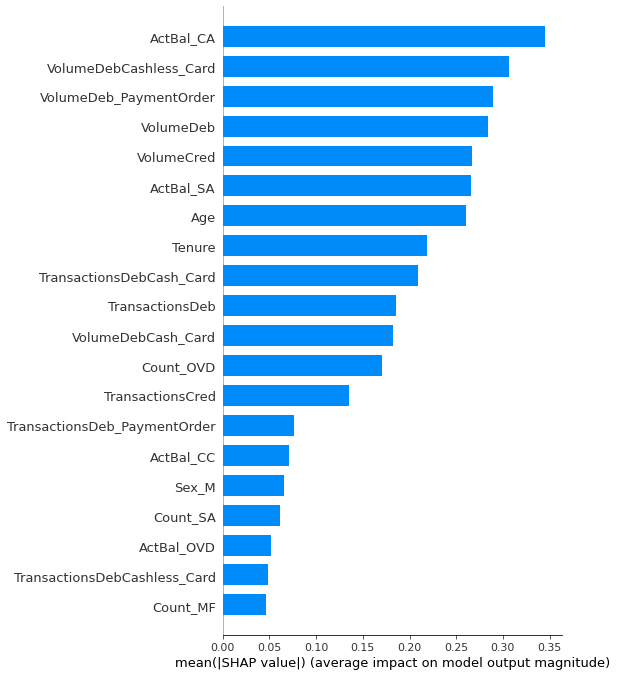

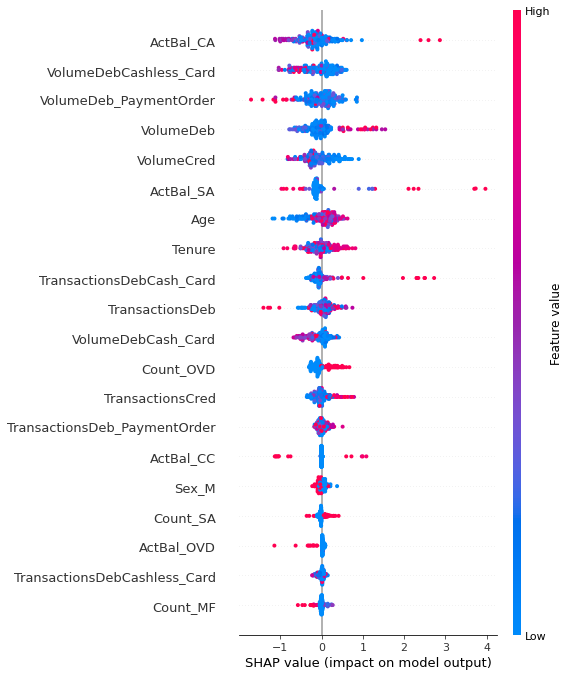

In [25]:
explainer = shap.TreeExplainer(model_cc)
explanation = explainer(X_test_cc)
shap_values = explainer.shap_values(X_test_cc)

shap.summary_plot(shap_values, X_test_cc, plot_type="bar")
shap.summary_plot(shap_values, X_test_cc)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_cc.iloc[0, :])

#### Model 2 - To predict wether a customer will buy a Mutual Fund <br> To also predicted the revenue from the client

In [26]:
#Model 2 - To predict wether a customer will buy a Mutual Fund or not
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_mf = df_combined.copy(deep=True)
X_mf = df_train_mf.drop(columns=target_cols+client_col).copy()
y_mf = df_combined['Sale_MF']

y_mf_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  # The Client column maintains the original index
    'Sale_CC': y_mf  # The target variable maintains the original index
})

# Split into train test and val - 80 10 10 split - change the random state since we dont want to same split for all 3 models
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_mf, y_mf, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_mf = XGBClassifier(n_estimators = 50)
model_mf.fit(X_train_mf, y_train_mf)
preds = model_mf.predict(X_test_mf)
preds_prob = model_mf.predict_proba(X_test_mf)

accuracy = accuracy_score(y_test_mf, preds)
print(f"Val acc :{accuracy:.4f}")

scores = { 'y_test':y_test_mf, 'pred': preds, 'prob':preds_prob[:,1]}
scores_mf = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_mf)

## Regression

from sklearn.linear_model import  LinearRegression
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_mf = df_combined.copy(deep=True)
X_mf_rev = df_train_mf.drop(columns=target_cols+client_col).copy()
y_mf_rev = df_combined['Revenue_MF']

y_mf_rev_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  # The Client column maintains the original index
    'Revenue_MF': y_mf_rev  # The target variable maintains the original index
})

# Split into train test and val - 80 20
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_mf_rev, y_mf_rev, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_mf_rev = LinearRegression()
model_mf_rev.fit(X_train_rev, y_train_rev)
preds = model_mf_rev.predict(X_test_rev)

scores = { 'y_rev':y_test_rev, 'pred': preds}
scores_mf_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)
display(scores_mf_rev)

Val acc :0.7526


,y_test,pred,prob
432,1,1,0.954828
50,1,1,0.922069
111,0,1,0.895138
651,0,1,0.867325
473,1,1,0.864821
...,...,...,...
494,0,0,0.004911
347,0,0,0.004126
433,1,0,0.003895
717,0,0,0.002672


,y_rev,pred
455,0.601071,10.806129
194,0.000000,7.628703
605,2.999286,7.217219
836,0.000000,6.947965
314,0.916786,5.961912
...,...,...
899,0.000000,-3.092854
6,0.000000,-4.472774
307,0.000000,-4.680517
726,0.000000,-7.184573


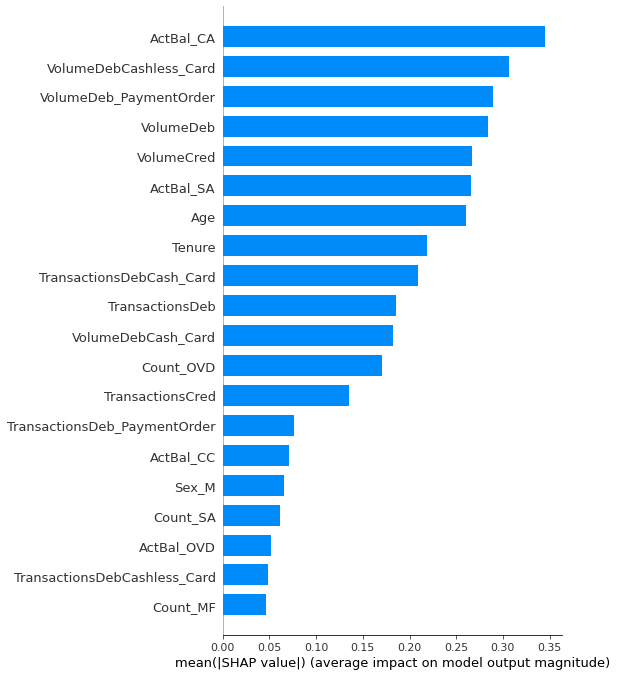

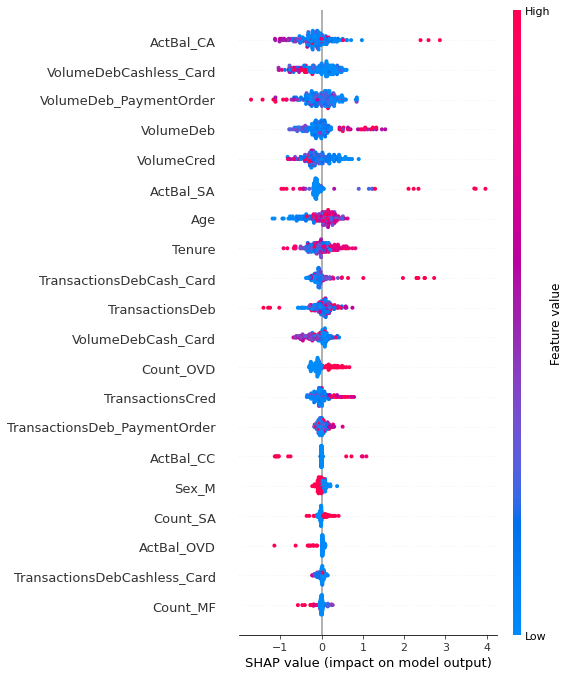

In [27]:
explainer = shap.TreeExplainer(model_cc)
explanation = explainer(X_test_mf)
shap_values = explainer.shap_values(X_test_mf)

shap.summary_plot(shap_values, X_test_mf, plot_type="bar")
shap.summary_plot(shap_values, X_test_mf)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test_mf.iloc[0, :])

#### Model 3 - To predict wether a customer will take a loan <br> To also predicted the revenue from the client

In [28]:
#Model 3 - To predict wether a customer will buy a loan or not
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_cl = df_combined.copy(deep=True)
X_cl = df_train_cl.drop(columns=target_cols+client_col).copy()
y_cl = df_combined['Sale_CL']

y_cl_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  
    'Sale_CC': y_cl  
})

# Split into train test and val - 80 20
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_cl = XGBClassifier(n_estimators = 50)
model_cl.fit(X_train_cl, y_train_cl)
preds = model_cl.predict(X_test_cl)
preds_prob = model_cl.predict_proba(X_test_cl)

accuracy = accuracy_score(y_test_cl, preds)
print(f"Val acc :{accuracy:.4f}")

scores = { 'y_test':y_test_cl, 'pred': preds, 'prob':preds_prob[:,1]}
scores_cl = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_cl)

## Regression

from sklearn.linear_model import  LinearRegression
target_cols = ['Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL']
client_col = ['Client']
df_train_cl = df_combined.copy(deep=True)
X_cl_rev = df_train_cl.drop(columns=target_cols+client_col).copy()
y_cl_rev = df_combined['Revenue_CL']

y_cl_rev_with_client = pd.DataFrame({
    'Client': df_combined['Client'],  # The Client column maintains the original index
    'Revenue_CL': y_cl_rev  # The target variable maintains the original index
})

# Split into train test and val - 80 10 10 split
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_cl_rev, y_cl_rev, test_size=0.2, random_state=1)

# Train a simple xgboost model first
model_cl_rev = LinearRegression()
model_cl_rev.fit(X_train_rev, y_train_rev)
preds = model_cl_rev.predict(X_test_rev)

scores = { 'y_rev':y_test_rev, 'pred': preds}
scores_cl_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)
display(scores_cl_rev)

Val acc :0.6895


,y_test,pred,prob
836,0,1,0.971584
6,1,1,0.957570
56,1,1,0.917739
784,1,1,0.877156
592,1,1,0.859218
...,...,...,...
386,0,0,0.006756
551,0,0,0.006198
644,0,0,0.005889
858,0,0,0.002849


,y_rev,pred
853,19.035714,21.412489
732,9.964286,10.584810
6,24.434643,9.757759
414,0.000000,9.198020
189,11.546071,9.118409
...,...,...
600,0.000000,-1.090545
455,0.000000,-1.249199
850,0.000000,-1.425586
674,0.000000,-1.512362


### Run Model on All Clients

In [34]:
## RUN MODEL ON ALL THE DATA
model_cc.fit(X_cc, y_cc)
preds = model_cc.predict(X_cc)
preds_prob = model_cc.predict_proba(X_cc)

scores = { 'y':y_cc, 'pred': preds, 'prob':preds_prob[:,1], 'Client': y_cc_with_client['Client']}
scores_all_cc = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_all_cc)

model_cc_rev.fit(X_cc_rev, y_cc_rev)
preds = model_cc_rev.predict(X_cc_rev)
scores = { 'y':y_cc_rev, 'pred': preds, 'Client': y_cc_rev_with_client['Client']}
scores_all_cc_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)

model_mf.fit(X_mf, y_mf)
preds = model_mf.predict(X_mf)
preds_prob = model_mf.predict_proba(X_mf)

scores = { 'y':y_mf, 'pred': preds, 'prob':preds_prob[:,1], 'Client': y_mf_with_client['Client']}
scores_all_mf = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_all_mf)

model_mf_rev.fit(X_mf_rev, y_mf_rev)
preds = model_mf_rev.predict(X_mf_rev)
scores = { 'y':y_mf_rev, 'pred': preds, 'Client': y_mf_rev_with_client['Client']}
scores_all_mf_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)

model_cl.fit(X_cl, y_cl)
preds = model_cl.predict(X_cl)
preds_prob = model_cl.predict_proba(X_cl)

scores = { 'y':y_cl, 'pred': preds, 'prob':preds_prob[:,1], 'Client': y_cl_with_client['Client']}
scores_all_cl = pd.DataFrame(scores).sort_values('prob', ascending=False)
display(scores_all_cl)

model_cl_rev.fit(X_cl_rev, y_cl_rev)
preds = model_cl_rev.predict(X_cl_rev)
scores = { 'y':y_cl_rev, 'pred': preds, 'Client': y_cl_rev_with_client['Client']}
scores_all_cl_rev = pd.DataFrame(scores).sort_values('pred', ascending=False)


,y,pred,prob,Client
355,1,1,0.992523,385
337,1,1,0.988672,1175
407,1,1,0.986929,219
294,1,1,0.986833,1344
634,1,1,0.985936,721
...,...,...,...,...
614,0,0,0.004111,691
83,0,0,0.003959,865
466,0,0,0.003697,630
827,0,0,0.003361,1283


,y,pred,prob,Client
21,1,1,0.985202,390
413,1,1,0.972109,544
27,1,1,0.971111,416
432,1,1,0.969340,790
164,1,1,0.962964,287
...,...,...,...,...
386,0,0,0.002566,1490
268,0,0,0.002561,642
907,0,0,0.001280,1224
316,0,0,0.001080,800


,y,pred,prob,Client
857,1,1,0.994791,298
679,1,1,0.989496,249
766,1,1,0.989045,1291
279,1,1,0.986128,846
595,1,1,0.985839,1169
...,...,...,...,...
386,0,0,0.003941,1490
464,0,0,0.003253,479
499,0,0,0.002141,378
427,0,0,0.001932,602


### Calculating KS to Check the deciles to target

In [35]:
def ks(data=None,target=None, prob=None):

    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')

    grouped = data.groupby('bucket', as_index = False)

    kstable = pd.DataFrame()

    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']

    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)

    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)

    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)

    display(kstable)
    
    return(kstable)

In [36]:
cc_ks_test = ks(data=scores_all_cc,target='pred',prob="prob")
mf_ks_test = ks(data=scores_all_mf, target='pred',prob="prob")
cl_ks_test = ks(data=scores_all_cl, target='pred',prob="prob")

 



 

 



C:\Users\Admin\AppData\Local\Temp/ipykernel_38468/914885402.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('bucket', as_index = False)


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,0.854705,0.992523,95,0,41.48%,0.00%,41.48%,0.00%,41.5
1,0.695380,0.854181,95,0,41.48%,0.00%,82.97%,0.00%,83.0
2,0.140207,0.694632,39,56,17.03%,7.78%,100.00%,7.78%,92.2
3,0.101155,0.138990,0,95,0.00%,13.19%,100.00%,20.97%,79.0
4,0.073826,0.101069,0,94,0.00%,13.06%,100.00%,34.03%,66.0
5,0.057111,0.073531,0,95,0.00%,13.19%,100.00%,47.22%,52.8
6,0.042350,0.057100,0,95,0.00%,13.19%,100.00%,60.42%,39.6
7,0.030158,0.042338,0,95,0.00%,13.19%,100.00%,73.61%,26.4
8,0.018227,0.030105,0,95,0.00%,13.19%,100.00%,86.81%,13.2
9,0.002419,0.018196,0,95,0.00%,13.19%,100.00%,100.00%,0.0


C:\Users\Admin\AppData\Local\Temp/ipykernel_38468/914885402.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('bucket', as_index = False)


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,0.826720,0.985202,95,0,49.22%,0.00%,49.22%,0.00%,49.2
1,0.578343,0.824004,95,0,49.22%,0.00%,98.45%,0.00%,98.4
2,0.098565,0.578196,3,92,1.55%,12.17%,100.00%,12.17%,87.8
3,0.065260,0.098398,0,95,0.00%,12.57%,100.00%,24.74%,75.3
4,0.049581,0.065070,0,94,0.00%,12.43%,100.00%,37.17%,62.8
5,0.036939,0.049445,0,95,0.00%,12.57%,100.00%,49.74%,50.3
6,0.027963,0.036886,0,95,0.00%,12.57%,100.00%,62.30%,37.7
7,0.020604,0.027931,0,95,0.00%,12.57%,100.00%,74.87%,25.1
8,0.012262,0.020573,0,95,0.00%,12.57%,100.00%,87.43%,12.6
9,0.000884,0.012148,0,95,0.00%,12.57%,100.00%,100.00%,0.0


C:\Users\Admin\AppData\Local\Temp/ipykernel_38468/914885402.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('bucket', as_index = False)


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
0,0.920644,0.994791,95,0,32.99%,0.00%,32.99%,0.00%,33.0
1,0.819734,0.920547,95,0,32.99%,0.00%,65.97%,0.00%,66.0
2,0.559050,0.819282,95,0,32.99%,0.00%,98.96%,0.00%,99.0
3,0.110791,0.553029,3,92,1.04%,13.92%,100.00%,13.92%,86.1
4,0.080610,0.109814,0,94,0.00%,14.22%,100.00%,28.14%,71.9
5,0.061798,0.080266,0,95,0.00%,14.37%,100.00%,42.51%,57.5
6,0.044761,0.061298,0,95,0.00%,14.37%,100.00%,56.88%,43.1
7,0.032406,0.044662,0,95,0.00%,14.37%,100.00%,71.26%,28.7
8,0.020869,0.032290,0,95,0.00%,14.37%,100.00%,85.63%,14.4
9,0.001709,0.020823,0,95,0.00%,14.37%,100.00%,100.00%,0.0


### Stratergy for selecting clients - 
#### Take the top 15% of cliens with the highest predicted probablity for each class.

In [37]:
all_cc_rev_class = scores_all_cc_rev.merge(scores_all_cc, on='Client', suffixes=['_Rev', '_Class'])
top_15_perc_cc = all_cc_rev_class.nlargest(math.floor(len(all_cc_rev_class)*0.15), 'prob')
display(top_15_perc_cc)

total_cc_revenue_pred = top_15_perc_cc.pred_Rev.sum()
total_cc_revenue_act = top_15_perc_cc.y_Rev.sum()
print(total_cc_revenue_pred, total_cc_revenue_act)

all_mf_rev_class = scores_all_mf_rev.merge(scores_all_mf, on='Client', suffixes=['_Rev', '_Class'])
top_15_perc_mf = all_mf_rev_class.nlargest(math.floor(len(all_mf_rev_class)*0.15), 'prob')
display(top_15_perc_mf)

total_mf_revenue_pred = top_15_perc_mf.pred_Rev.sum()
total_mf_revenue_act = top_15_perc_mf.y_Rev.sum()
print(total_mf_revenue_pred, total_mf_revenue_act)

all_cl_rev_class = scores_all_cl_rev.merge(scores_all_cl, on='Client', suffixes=['_Rev', '_Class'])
top_15_perc_cl = all_cl_rev_class.nlargest(math.floor(len(all_cl_rev_class)*0.15), 'prob')
display(top_15_perc_cl)

total_cl_revenue_pred = top_15_perc_cl.pred_Rev.sum()
total_cl_revenue_act = top_15_perc_cl.y_Rev.sum()
print(total_cl_revenue_pred, total_cl_revenue_act)


,y_Rev,pred_Rev,Client,y_Class,pred_Class,prob,target0,bucket
11,4.500000,8.948274,385,1,1,0.992523,0,"(0.854, 0.993]"
176,5.179643,4.862583,1175,1,1,0.988672,0,"(0.854, 0.993]"
28,4.286786,7.720386,219,1,1,0.986929,0,"(0.854, 0.993]"
64,2.857143,6.910793,1344,1,1,0.986833,0,"(0.854, 0.993]"
171,4.464286,4.923521,721,1,1,0.985936,0,"(0.854, 0.993]"
...,...,...,...,...,...,...,...,...
72,76.859286,6.746580,374,1,1,0.796158,0,"(0.695, 0.854]"
281,12.256429,3.392163,103,1,1,0.795596,0,"(0.695, 0.854]"
61,12.765357,6.961834,1205,1,1,0.794328,0,"(0.695, 0.854]"
185,2.138571,4.738526,739,1,1,0.790169,0,"(0.695, 0.854]"


590.5273383668906 1841.077142857143


,y_Rev,pred_Rev,Client,y_Class,pred_Class,prob,target0,bucket
1,1.379821,11.502469,390,1,1,0.985202,0,"(0.825, 0.985]"
5,0.059821,7.555740,544,1,1,0.972109,0,"(0.825, 0.985]"
12,10.363036,5.811567,416,1,1,0.971111,0,"(0.825, 0.985]"
45,6.080179,4.289593,790,1,1,0.969340,0,"(0.825, 0.985]"
211,18.486786,2.983686,287,1,1,0.962964,0,"(0.825, 0.985]"
...,...,...,...,...,...,...,...,...
145,10.284643,3.274816,632,1,1,0.741873,0,"(0.578, 0.825]"
789,0.641607,0.774080,203,1,1,0.739783,0,"(0.578, 0.825]"
283,1.473214,2.658326,132,1,1,0.739129,0,"(0.578, 0.825]"
750,2.231964,0.997318,883,1,1,0.738728,0,"(0.578, 0.825]"


396.3186235170623 1472.5889285714286


,y_Rev,pred_Rev,Client,y_Class,pred_Class,prob,target0,bucket
81,22.966429,6.499982,298,1,1,0.994791,0,"(0.921, 0.995]"
90,11.750000,6.365931,249,1,1,0.989496,0,"(0.921, 0.995]"
35,11.101429,7.857420,1291,1,1,0.989045,0,"(0.921, 0.995]"
110,2.553571,6.053545,846,1,1,0.986128,0,"(0.921, 0.995]"
78,46.392857,6.586949,1169,1,1,0.985839,0,"(0.921, 0.995]"
...,...,...,...,...,...,...,...,...
260,4.785714,4.839380,1246,1,1,0.874896,0,"(0.819, 0.921]"
504,18.353929,3.403153,73,1,1,0.873844,0,"(0.819, 0.921]"
769,6.678571,1.670226,1527,1,1,0.873239,0,"(0.819, 0.921]"
207,12.964286,5.179307,1025,1,1,0.871815,0,"(0.819, 0.921]"


873.2880455300424 1758.1182142857144


In [38]:
top_15_perc_cc['Max_Rev_Pred_Label'] = 'CC'
top_15_perc_mf['Max_Rev_Pred_Label'] = 'MF'
top_15_perc_cl['Max_Rev_Pred_Label'] = 'CL'

top_15_perc_cc['Max_Rev_Act_Label'] = 'CC'
top_15_perc_mf['Max_Rev_Act_Label'] = 'MF'
top_15_perc_cl['Max_Rev_Act_Label'] = 'CL'

top_15_perc_cc['Max_Rev_Pred'] = top_15_perc_cc['pred_Rev']
top_15_perc_mf['Max_Rev_Pred'] = top_15_perc_mf['pred_Rev']
top_15_perc_cl['Max_Rev_Pred'] = top_15_perc_cl['pred_Rev']

top_15_perc_cc['Max_Rev_Act'] = top_15_perc_cc['y_Rev']
top_15_perc_mf['Max_Rev_Act'] = top_15_perc_mf['y_Rev']
top_15_perc_cl['Max_Rev_Act'] = top_15_perc_cl['y_Rev']


### Checking the overlapping clients as we can only make 1 offer to each client 

In [39]:
overlapping_clients = top_15_perc_cc.merge(top_15_perc_mf, on='Client', suffixes=['_cc', '_mf']).merge(top_15_perc_cl, on='Client')

overlapping_clients['Max_Rev_Pred'] = overlapping_clients[['pred_Rev_cc', 'pred_Rev_mf', 'pred_Rev']].max(axis=1)
overlapping_clients['Max_Rev_Pred_Label'] = overlapping_clients[['pred_Rev_cc', 'pred_Rev_mf', 'pred_Rev']].idxmax(axis=1)

overlapping_clients['Max_Rev_Act'] = overlapping_clients[['y_Rev_cc', 'y_Rev_mf', 'y_Rev']].max(axis=1)
overlapping_clients['Max_Rev_Act_Label'] = overlapping_clients[['y_Rev_cc', 'y_Rev_mf', 'y_Rev']].idxmax(axis=1)

mapping_pred = {'pred_Rev_cc': 'CC', 'pred_Rev_mf': 'MF', 'pred_Rev': 'CL'}
mapping_act = {'y_Rev_cc': 'CC', 'y_Rev_mf': 'MF', 'y_Rev': 'CL'}


overlapping_clients['Max_Rev_Pred_Label'] = overlapping_clients['Max_Rev_Pred_Label'].map(mapping_pred)
overlapping_clients['Max_Rev_Act_Label'] = overlapping_clients['Max_Rev_Act_Label'].map(mapping_act)


display(overlapping_clients)

ids_in_all = overlapping_clients.Client.unique()
ids_in_all

clients_mapping_overlap = [{'Client': row['Client'], 'Product Predicted': row['Max_Rev_Pred_Label'], 
                            'Revenue Predicted': row['Max_Rev_Pred'], 'Product Actual': row['Max_Rev_Act_Label'], 'Revenue Actual': row['Max_Rev_Act']} for ind,row in overlapping_clients.iterrows()] 

clients_mapping_overlap[0:5]

,y_Rev_cc,pred_Rev_cc,Client,y_Class_cc,pred_Class_cc,prob_cc,target0_cc,bucket_cc,Max_Rev_Pred_Label_cc,Max_Rev_Act_Label_cc,...,pred_Rev,y_Class,pred_Class,prob,target0,bucket,Max_Rev_Pred_Label,Max_Rev_Act_Label,Max_Rev_Pred,Max_Rev_Act
0,5.179643,4.862583,1175,1,1,0.988672,0,"(0.854, 0.993]",CC,CC,...,7.011879,1,1,0.889837,0,"(0.819, 0.921]",CL,CL,7.011879,12.785714
1,2.679286,3.770338,1549,1,1,0.945050,0,"(0.854, 0.993]",CC,CC,...,8.459184,1,1,0.967231,0,"(0.921, 0.995]",CL,CL,8.459184,133.275357
2,213.292857,11.208683,448,1,1,0.920679,0,"(0.854, 0.993]",CC,CC,...,7.824171,1,1,0.970001,0,"(0.921, 0.995]",CC,CC,11.208683,213.292857
3,5.142857,-2.586490,1399,1,1,0.878375,0,"(0.854, 0.993]",CC,CC,...,3.949026,1,1,0.935774,0,"(0.921, 0.995]",CL,MF,3.949026,27.233750
4,3.751071,6.270693,614,1,1,0.841264,0,"(0.695, 0.854]",CC,CC,...,2.714839,1,1,0.893981,0,"(0.819, 0.921]",CC,MF,6.270693,83.038036
5,1.321429,3.069737,639,1,1,0.818254,0,"(0.695, 0.854]",CC,CC,...,4.158584,1,1,0.951691,0,"(0.921, 0.995]",CL,CL,4.158584,11.571429


[{'Client': 1175,
  'Product Predicted': 'CL',
  'Revenue Predicted': 7.0118787862570935,
  'Product Actual': 'CL',
  'Revenue Actual': 12.785714285714286},
 {'Client': 1549,
  'Product Predicted': 'CL',
  'Revenue Predicted': 8.459183843763608,
  'Product Actual': 'CL',
  'Revenue Actual': 133.27535714285713},
 {'Client': 448,
  'Product Predicted': 'CC',
  'Revenue Predicted': 11.208682544675604,
  'Product Actual': 'CC',
  'Revenue Actual': 213.29285714285714},
 {'Client': 1399,
  'Product Predicted': 'CL',
  'Revenue Predicted': 3.9490255295805587,
  'Product Actual': 'MF',
  'Revenue Actual': 27.233749999999997},
 {'Client': 614,
  'Product Predicted': 'CC',
  'Revenue Predicted': 6.270693243895292,
  'Product Actual': 'MF',
  'Revenue Actual': 83.03803571428571}]

In [40]:
overlapping_clients_cc_mf = top_15_perc_cc.merge(top_15_perc_mf, on='Client', suffixes=['_cc','_mf'])

overlapping_clients_cc_mf = overlapping_clients_cc_mf[~overlapping_clients_cc_mf['Client'].isin(ids_in_all)]

overlapping_clients_cc_mf['Max_Rev_Pred'] = overlapping_clients_cc_mf[['pred_Rev_cc', 'pred_Rev_mf']].max(axis=1)
overlapping_clients_cc_mf['Max_Rev_Pred_Label'] = overlapping_clients_cc_mf[['pred_Rev_cc', 'pred_Rev_mf']].idxmax(axis=1)

overlapping_clients_cc_mf['Max_Rev_Act'] = overlapping_clients_cc_mf[['y_Rev_cc', 'y_Rev_mf']].max(axis=1)
overlapping_clients_cc_mf['Max_Rev_Act_Label'] = overlapping_clients_cc_mf[['y_Rev_cc', 'y_Rev_mf']].idxmax(axis=1)

mapping_pred = {'pred_Rev_cc': 'CC', 'pred_Rev_mf': 'MF'}
mapping_act = {'y_Rev_cc': 'CC', 'y_Rev_mf': 'MF'}

overlapping_clients_cc_mf['Max_Rev_Pred_Label'] = overlapping_clients_cc_mf['Max_Rev_Pred_Label'].map(mapping_pred)
overlapping_clients_cc_mf['Max_Rev_Act_Label'] = overlapping_clients_cc_mf['Max_Rev_Act_Label'].map(mapping_act)


ids_in_cc_mf = overlapping_clients_cc_mf.Client.unique()

overlapping_clients_cc_mf

clients_mapping_overlap_cc_mf = [{'Client': row['Client'], 'Product Predicted': row['Max_Rev_Pred_Label'], 
                            'Revenue Predicted': row['Max_Rev_Pred'], 'Product Actual': row['Max_Rev_Act_Label'], 
                            'Revenue Actual': row['Max_Rev_Act']} for ind,row in overlapping_clients_cc_mf.iterrows()] 

clients_mapping_overlap_cc_mf[0:5]

[{'Client': 1413,
  'Product Predicted': 'MF',
  'Revenue Predicted': 1.989037961301437,
  'Product Actual': 'CC',
  'Revenue Actual': 6.964285714285714},
 {'Client': 1571,
  'Product Predicted': 'MF',
  'Revenue Predicted': 2.1310417461885818,
  'Product Actual': 'CC',
  'Revenue Actual': 4.571428571428571},
 {'Client': 529,
  'Product Predicted': 'CC',
  'Revenue Predicted': 2.4575190295928677,
  'Product Actual': 'CC',
  'Revenue Actual': 1.7867857142857144},
 {'Client': 43,
  'Product Predicted': 'CC',
  'Revenue Predicted': 9.893976073892038,
  'Product Actual': 'MF',
  'Revenue Actual': 73.04178571428572},
 {'Client': 1383,
  'Product Predicted': 'MF',
  'Revenue Predicted': 1.887666546612362,
  'Product Actual': 'MF',
  'Revenue Actual': 10.90982142857143}]

In [41]:
overlapping_clients_cc_cl = top_15_perc_cc.merge(top_15_perc_cl, on='Client', suffixes=['_cc','_cl'])

overlapping_clients_cc_cl = overlapping_clients_cc_cl[~overlapping_clients_cc_cl['Client'].isin(ids_in_all)]

overlapping_clients_cc_cl['Max_Rev_Pred'] = overlapping_clients_cc_cl[['pred_Rev_cc', 'pred_Rev_cl']].max(axis=1)
overlapping_clients_cc_cl['Max_Rev_Pred_Label'] = overlapping_clients_cc_cl[['pred_Rev_cc', 'pred_Rev_cl']].idxmax(axis=1)

overlapping_clients_cc_cl['Max_Rev_Act'] = overlapping_clients_cc_cl[['y_Rev_cc', 'y_Rev_cl']].max(axis=1)
overlapping_clients_cc_cl['Max_Rev_Act_Label'] = overlapping_clients_cc_cl[['y_Rev_cc', 'y_Rev_cl']].idxmax(axis=1)

mapping_pred = {'pred_Rev_cc': 'CC', 'pred_Rev_cl': 'CL'}
mapping_act = {'y_Rev_cc': 'CC', 'y_Rev_cl': 'CL'}

overlapping_clients_cc_cl['Max_Rev_Pred_Label'] = overlapping_clients_cc_cl['Max_Rev_Pred_Label'].map(mapping_pred)
overlapping_clients_cc_cl['Max_Rev_Act_Label'] = overlapping_clients_cc_cl['Max_Rev_Act_Label'].map(mapping_act)


ids_in_cc_cl = overlapping_clients_cc_cl.Client.unique()

overlapping_clients_cc_cl

clients_mapping_overlap_cc_cl = [{'Client': row['Client'], 'Product Predicted': row['Max_Rev_Pred_Label'], 
                            'Revenue Predicted': row['Max_Rev_Pred'], 'Product Actual': row['Max_Rev_Act_Label'], 
                            'Revenue Actual': row['Max_Rev_Act']} for ind,row in overlapping_clients_cc_cl.iterrows()] 

clients_mapping_overlap_cc_cl[0:5]

[{'Client': 575,
  'Product Predicted': 'CL',
  'Revenue Predicted': 8.652795282806018,
  'Product Actual': 'CC',
  'Revenue Actual': 15.291785714285714},
 {'Client': 1030,
  'Product Predicted': 'CL',
  'Revenue Predicted': 6.018928529310218,
  'Product Actual': 'CL',
  'Revenue Actual': 8.428571428571429},
 {'Client': 1293,
  'Product Predicted': 'CC',
  'Revenue Predicted': 11.658395887385012,
  'Product Actual': 'CC',
  'Revenue Actual': 89.76107142857143},
 {'Client': 271,
  'Product Predicted': 'CL',
  'Revenue Predicted': 4.670146928028414,
  'Product Actual': 'CL',
  'Revenue Actual': 6.642857142857143},
 {'Client': 1041,
  'Product Predicted': 'CL',
  'Revenue Predicted': 4.250234456906542,
  'Product Actual': 'CL',
  'Revenue Actual': 17.563214285714285}]

In [42]:
overlapping_clients_mf_cl = top_15_perc_mf.merge(top_15_perc_cl, on='Client', suffixes=['_mf','_cl'])

overlapping_clients_mf_cl = overlapping_clients_mf_cl[~overlapping_clients_mf_cl['Client'].isin(ids_in_all)]

overlapping_clients_mf_cl['Max_Rev_Pred'] = overlapping_clients_mf_cl[['pred_Rev_mf', 'pred_Rev_cl']].max(axis=1)
overlapping_clients_mf_cl['Max_Rev_Pred_Label'] = overlapping_clients_mf_cl[['pred_Rev_mf', 'pred_Rev_cl']].idxmax(axis=1)

overlapping_clients_mf_cl['Max_Rev_Act'] = overlapping_clients_mf_cl[['y_Rev_mf', 'y_Rev_cl']].max(axis=1)
overlapping_clients_mf_cl['Max_Rev_Act_Label'] = overlapping_clients_mf_cl[['y_Rev_mf', 'y_Rev_cl']].idxmax(axis=1)

mapping_pred = {'pred_Rev_mf': 'MF', 'pred_Rev_cl': 'CL'}
mapping_act = {'y_Rev_mf': 'MF', 'y_Rev_cl': 'CL'}

overlapping_clients_mf_cl['Max_Rev_Pred_Label'] = overlapping_clients_mf_cl['Max_Rev_Pred_Label'].map(mapping_pred)
overlapping_clients_mf_cl['Max_Rev_Act_Label'] = overlapping_clients_mf_cl['Max_Rev_Act_Label'].map(mapping_act)


ids_in_mf_cl = overlapping_clients_mf_cl.Client.unique()

overlapping_clients_mf_cl

clients_mapping_overlap_mf_cl = [{'Client': row['Client'], 'Product Predicted': row['Max_Rev_Pred_Label'], 
                            'Revenue Predicted': row['Max_Rev_Pred'], 'Product Actual': row['Max_Rev_Act_Label'], 
                            'Revenue Actual': row['Max_Rev_Act']} for ind,row in overlapping_clients_mf_cl.iterrows()] 

clients_mapping_overlap_mf_cl[0:5]

[{'Client': 544,
  'Product Predicted': 'MF',
  'Revenue Predicted': 7.55574012238173,
  'Product Actual': 'CL',
  'Revenue Actual': 17.785714285714285},
 {'Client': 1091,
  'Product Predicted': 'CL',
  'Revenue Predicted': 6.321341678872303,
  'Product Actual': 'CL',
  'Revenue Actual': 10.107142857142858},
 {'Client': 1220,
  'Product Predicted': 'CL',
  'Revenue Predicted': 6.750705935573566,
  'Product Actual': 'MF',
  'Revenue Actual': 4.910714285714286},
 {'Client': 102,
  'Product Predicted': 'CL',
  'Revenue Predicted': 7.125039897448217,
  'Product Actual': 'CL',
  'Revenue Actual': 6.9525},
 {'Client': 557,
  'Product Predicted': 'CL',
  'Revenue Predicted': 6.397826788455125,
  'Product Actual': 'CL',
  'Revenue Actual': 2.380714285714286}]

### Checking for non-overlapping clients

In [43]:
shared_ids = np.concatenate((ids_in_all , ids_in_cc_mf , ids_in_cc_cl , ids_in_mf_cl)) 

df_all = pd.concat([top_15_perc_cc, top_15_perc_cl, top_15_perc_mf], axis=0, ignore_index=True)
df_all = df_all[~df_all['Client'].isin(shared_ids)]
display(df_all)

clients_mapping_ind = [{'Client': row['Client'], 'Product Predicted': row['Max_Rev_Pred_Label'], 
                            'Revenue Predicted': row['Max_Rev_Pred'], 'Product Actual': row['Max_Rev_Act_Label'], 
                            'Revenue Actual': row['Max_Rev_Act']} for ind,row in df_all.iterrows()] 
clients_mapping_ind[0:5]

,y_Rev,pred_Rev,Client,y_Class,pred_Class,prob,target0,bucket,Max_Rev_Pred_Label,Max_Rev_Act_Label,Max_Rev_Pred,Max_Rev_Act
0,4.500000,8.948274,385,1,1,0.992523,0,"(0.854, 0.993]",CC,CC,8.948274,4.500000
2,4.286786,7.720386,219,1,1,0.986929,0,"(0.854, 0.993]",CC,CC,7.720386,4.286786
3,2.857143,6.910793,1344,1,1,0.986833,0,"(0.854, 0.993]",CC,CC,6.910793,2.857143
4,4.464286,4.923521,721,1,1,0.985936,0,"(0.854, 0.993]",CC,CC,4.923521,4.464286
5,0.893929,2.083256,1170,1,1,0.984919,0,"(0.854, 0.993]",CC,CC,2.083256,0.893929
...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.641250,2.147384,292,1,1,0.747290,0,"(0.578, 0.825]",MF,MF,2.147384,0.641250
422,0.641607,0.774080,203,1,1,0.739783,0,"(0.578, 0.825]",MF,MF,0.774080,0.641607
423,1.473214,2.658326,132,1,1,0.739129,0,"(0.578, 0.825]",MF,MF,2.658326,1.473214
424,2.231964,0.997318,883,1,1,0.738728,0,"(0.578, 0.825]",MF,MF,0.997318,2.231964


[{'Client': 385,
  'Product Predicted': 'CC',
  'Revenue Predicted': 8.948274265683505,
  'Product Actual': 'CC',
  'Revenue Actual': 4.5},
 {'Client': 219,
  'Product Predicted': 'CC',
  'Revenue Predicted': 7.720386051264662,
  'Product Actual': 'CC',
  'Revenue Actual': 4.286785714285714},
 {'Client': 1344,
  'Product Predicted': 'CC',
  'Revenue Predicted': 6.910792990160947,
  'Product Actual': 'CC',
  'Revenue Actual': 2.857142857142857},
 {'Client': 721,
  'Product Predicted': 'CC',
  'Revenue Predicted': 4.923521083569241,
  'Product Actual': 'CC',
  'Revenue Actual': 4.464285714285714},
 {'Client': 1170,
  'Product Predicted': 'CC',
  'Revenue Predicted': 2.083256377933857,
  'Product Actual': 'CC',
  'Revenue Actual': 0.8939285714285715}]

### Preparing Final Dataframe of Clients

In [44]:
final_clients_mapping = clients_mapping_overlap + clients_mapping_overlap_cc_cl + clients_mapping_overlap_cc_mf + clients_mapping_overlap_mf_cl + clients_mapping_ind
revenue_df = pd.DataFrame(final_clients_mapping)
revenue_df


,Client,Product Predicted,Revenue Predicted,Product Actual,Revenue Actual
0,1175,CL,7.011879,CL,12.785714
1,1549,CL,8.459184,CL,133.275357
2,448,CC,11.208683,CC,213.292857
3,1399,CL,3.949026,MF,27.233750
4,614,CC,6.270693,MF,83.038036
...,...,...,...,...,...
354,292,MF,2.147384,MF,0.641250
355,203,MF,0.774080,MF,0.641607
356,132,MF,2.658326,MF,1.473214
357,883,MF,0.997318,MF,2.231964


In [45]:
revenue_pred = revenue_df.groupby('Product Predicted')['Revenue Predicted'].sum().reset_index()
revenue_act = revenue_df.groupby('Product Actual')['Revenue Actual'].sum().reset_index()

display(revenue_pred, revenue_act)

,Product Predicted,Revenue Predicted
0,CC,502.629543
1,CL,830.283601
2,MF,325.921424


,Product Actual,Revenue Actual
0,CC,1741.710357
1,CL,1640.528571
2,MF,1404.098750


In [ ]:
## Save To CSV
revenue_df[['Client', 'Product Predicted', 'Revenue Predicted']].to_csv('Clients Selected by Predicted Revenue.csv', index=False)
revenue_df[['Client', 'Product Actual', 'Revenue Actual']].to_csv('Clients Selected by Actual Revenue.csv', index=False)
